**Insights from Failed Orders**

In this notebook, we'll analyze some order data from the Ground Transportation Manager platform, Gett. 

The full project description can be found here: 
- https://platform.stratascratch.com/data-projects/insights-failed-orders

We will investigate the following questions:
1. Build up distribution of orders according to reasons for failure: cancellations before and after driver assignment, and reasons for order rejection. Analyse the resulting plot. Which category has the highest number of orders?
2. Plot the distribution of failed orders by hours. Is there a trend that certain hours have an abnormally high proportion of one category or another? What hours are the biggest fails? How can this be explained?
3. Plot the average time to cancellation with and without driver, by the hour. If there are any outliers in the data, it would be better to remove them. Can we draw any conclusions from this plot?
4. Plot the distribution of average ETA by hours. How can this plot be explained?
5. BONUS Hexagons. Using the h3 and folium packages, calculate how many sizes 8 hexes contain 80% of all orders from the original data sets and visualise the hexes, colouring them by the number of fails on the map.

In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [127]:
offers_df = pd.read_csv('datasets\data_offers.csv')
orders_df = pd.read_csv('datasets\data_orders.csv')

Doesn't look like offers_df contains any data relevant for the analysis - not quite sure what offer_id is.

In [128]:
offers_df.head()

,order_gk,offer_id
0,3000579625629,300050936206
1,3000627306450,300052064651
2,3000632920686,300052408812
3,3000632771725,300052393030
4,3000583467642,300051001196


In [129]:
orders_df.head()

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0
2,12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0
3,13:50:20,-1.054671,51.460544,658.0,3000582941169,4,1,62.0
4,21:24:45,-0.967605,51.458236,NaN,3000583140877,9,0,NaN


In [130]:
orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10716 entries, 0 to 10715
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_datetime                 10716 non-null  object 
 1   origin_longitude               10716 non-null  float64
 2   origin_latitude                10716 non-null  float64
 3   m_order_eta                    2814 non-null   float64
 4   order_gk                       10716 non-null  int64  
 5   order_status_key               10716 non-null  int64  
 6   is_driver_assigned_key         10716 non-null  int64  
 7   cancellations_time_in_seconds  7307 non-null   float64
dtypes: float64(4), int64(3), object(1)
memory usage: 669.9+ KB


In [131]:
offers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334363 entries, 0 to 334362
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype
---  ------    --------------   -----
 0   order_gk  334363 non-null  int64
 1   offer_id  334363 non-null  int64
dtypes: int64(2)
memory usage: 5.1 MB


In [132]:
# combined_df = pd.merge(left=orders_df, right=offers_df, how='left', on='order_gk')
# combined_df.head()

In [133]:
orders_df['order_status_key'].value_counts()

order_status_key
4    7307
9    3409
Name: count, dtype: int64

In [134]:
orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10716 entries, 0 to 10715
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_datetime                 10716 non-null  object 
 1   origin_longitude               10716 non-null  float64
 2   origin_latitude                10716 non-null  float64
 3   m_order_eta                    2814 non-null   float64
 4   order_gk                       10716 non-null  int64  
 5   order_status_key               10716 non-null  int64  
 6   is_driver_assigned_key         10716 non-null  int64  
 7   cancellations_time_in_seconds  7307 non-null   float64
dtypes: float64(4), int64(3), object(1)
memory usage: 669.9+ KB


In [135]:
order_status_map = {
    4: 'Client Cancelled',
    9: 'System Cancelled'
}

orders_df['order_status'] = orders_df['order_status_key'].map(order_status_map)

is_driver_assigned_map = {
    0: 'No',
    1: 'Yes'
}

orders_df['is_driver_assigned'] = orders_df['is_driver_assigned_key'].map(is_driver_assigned_map)

In [136]:
orders_df['order_status'].value_counts(dropna=False)

order_status
Client Cancelled    7307
System Cancelled    3409
Name: count, dtype: int64

In [137]:
orders_df['is_driver_assigned'].value_counts(dropna=False)

is_driver_assigned
No     7902
Yes    2814
Name: count, dtype: int64

**Question 1**

Build up distribution of orders according to reasons for failure: cancellations before and after driver assignment, and reasons for order rejection. Analyse the resulting plot. Which category has the highest number of orders?

First, let's break down orders by driver assignment status.

Then, for each driver assignment status, we'll examine the breakdown of orders cancelled by client/system.

Relevant columns to look at:
- order_status_key - indicates whether order cancelled by client (4) or system (9)
- is_driver_assigned_key - indicates whether a driver has been assigned (0/1)

In [138]:
driver_assignment_proportions = orders_df['is_driver_assigned'].value_counts(normalize=True).reset_index()

pd.DataFrame(data=driver_assignment_proportions, index=driver_assignment_proportions.index).rename(columns={'is_driver_assigned': 'Driver Assigned?', 'proportion':'Proportion'})

,Driver Assigned?,Proportion
0,No,0.737402
1,Yes,0.262598


Out of all cancelled orders: 
- 74% cancelled before driver assigned
- 26% cancelled after driver assigned

In [139]:
# breakdown by driver assignment status
cancelled_before = orders_df[orders_df['is_driver_assigned_key']==0]
cancelled_after = orders_df[orders_df['is_driver_assigned_key']==1]

# breakdown by cancellation status
cancelled_before_reasons = cancelled_before['order_status'].value_counts()
cancelled_after_reasons = cancelled_after['order_status'].value_counts()

# breakdown by cancellation status, normalized
cancelled_before_reasons_normalized = cancelled_before['order_status'].value_counts()*100/len(cancelled_before)
cancelled_after_reasons_normalized = cancelled_after['order_status'].value_counts()*100/len(cancelled_after)

In [140]:
cancelled_info_df = pd.DataFrame(
    {
        'Driver Assigned: Count': cancelled_before_reasons, 
        'None Assigned: Count': cancelled_after_reasons, 
        'Driver Assigned: Percent': cancelled_before_reasons_normalized, 
        'None Assigned: Percent': cancelled_after_reasons_normalized
    },
)

cancelled_info_df.rename_axis('Order Status')

,Driver Assigned: Count,None Assigned: Count,Driver Assigned: Percent,None Assigned: Percent
Order Status,,,,
Client Cancelled,4496,2811,56.896988,99.89339
System Cancelled,3406,3,43.103012,0.10661


Out of all cancelled orders: 
- 74/26 split for orders cancelled before & after driver assignment, respectively

Orders cancelled before driver assigned:
- 57/43 split for orders cancelled by client/system, respectively

Orders cancelled after driver assigned:
- Nearly 100% of orders cancelled by client (2811/2814)

So, ~74% of cancelled orders were cancelled prior to driver assignment. Out of those orders, ~57% were cancelled by the client.

Additionally, nearly all orders that were cancelled by system (order_status_key = 9) occurred before driver assignment (3406 orders out of 3409). If an order was cancelled after a driver has been assigned, it was almost definitely cancelled by the client (2811 orders out of 2814).

https://seaborn.pydata.org/generated/seaborn.countplot.html

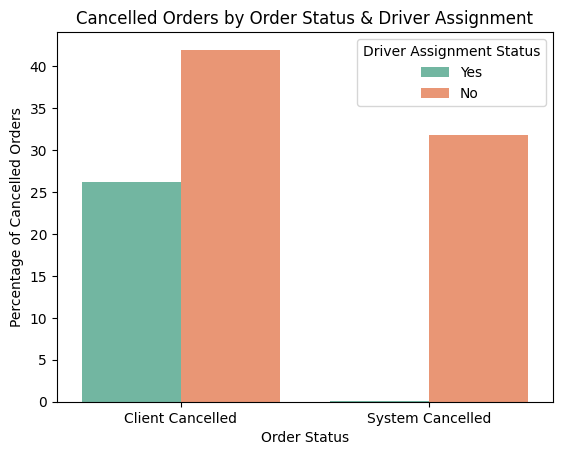

In [141]:
ax = sns.countplot(data=orders_df, x="order_status", hue="is_driver_assigned", palette="Set2", stat='percent')
plt.title("Cancelled Orders by Order Status & Driver Assignment")
plt.xlabel("Order Status")
plt.ylabel("Percentage of Cancelled Orders")
plt.legend(title="Driver Assignment Status")

plt.show()

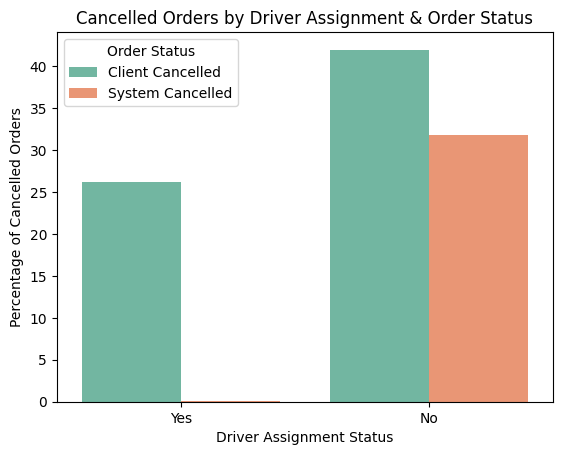

In [142]:
ax = sns.countplot(data=orders_df, x="is_driver_assigned", hue="order_status", palette="Set2", stat='percent')
plt.title("Cancelled Orders by Driver Assignment & Order Status")
plt.xlabel("Driver Assignment Status")
plt.ylabel("Percentage of Cancelled Orders")
plt.legend(title="Order Status")

plt.show()

**Question 2**

Plot the distribution of failed orders by hours. Is there a trend that certain hours have an abnormally high proportion of one category or another? What hours are the biggest fails? How can this be explained?

First, let's extract the hour from order_datetime.

In [143]:
time_info = orders_df['order_datetime'].str.split(":")

orders_df['hr'] = time_info.str[0]
orders_df['min'] = time_info.str[1]
orders_df['sec'] = time_info.str[2]

orders_df[['order_datetime', 'hr', 'min', 'sec']].head()

,order_datetime,hr,min,sec
0,18:08:07,18,08,07
1,20:57:32,20,57,32
2,12:07:50,12,07,50
3,13:50:20,13,50,20
4,21:24:45,21,24,45


Now, we can plot a breakdown of cancelled orders by hour.

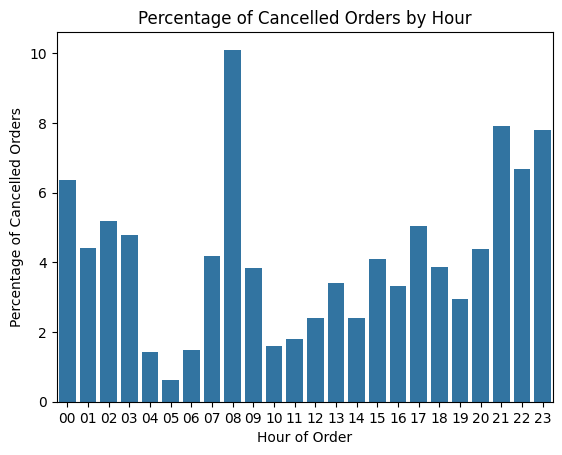

In [144]:
sns.countplot(data=orders_df, x="hr", order=sorted(orders_df["hr"].unique()), stat='percent')
plt.title("Percentage of Cancelled Orders by Hour")
plt.xlabel("Hour of Order")
plt.ylabel("Percentage of Cancelled Orders")
plt.show()

In [145]:
top_5_cancellation_times = orders_df['hr'].value_counts(normalize=True)[:5].reset_index()

pd.DataFrame(data=top_5_cancellation_times, index=top_5_cancellation_times.index).rename(columns={'proportion':'Proportion', 'hr':'Hour'})

,Hour,Proportion
0,08,0.100971
1,21,0.078947
2,23,0.078014
3,22,0.066816
4,00,0.063736


Orders are most frequently cancelled at the following times:
- 8 am (~10%)
- 9 pm-midnight (~28%)

Orders will tend to be cancelled at hours of day when rides are most frequently requested, as this is when drivers are likely to be busiest. The times mentioned above may be popular for requested rides for the following reasons: 
- 8 am is when many people may catch rides to go to work
- 9 pm-midnight may be a popular time for requesting rides for people who don't want to drive late at night

Of course, there may be other reasons besides those listed above that may explain high cancelled order counts at those hours.

**Question 3**

Plot the average time to cancellation with and without driver, by the hour. If there are any outliers in the data, it would be better to remove them. Can we draw any conclusions from this plot?

Let's look at the distribution of cancellation times (how many seconds passed before cancellation).

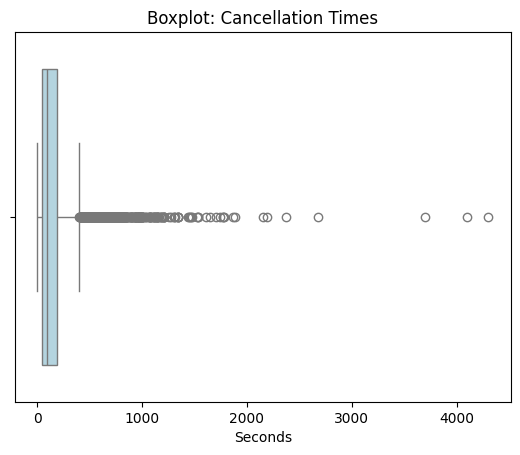

In [146]:
sns.boxplot(data=orders_df, x="cancellations_time_in_seconds", color="lightblue")
plt.title("Boxplot: Cancellation Times")
plt.xlabel("Seconds")
plt.show()

In [147]:
orders_df['cancellations_time_in_seconds'].describe()

count    7307.000000
mean      157.892021
std       213.366963
min         3.000000
25%        45.000000
50%        98.000000
75%       187.500000
max      4303.000000
Name: cancellations_time_in_seconds, dtype: float64

In [148]:
# cancellation time quantiles
cancellation_time_quantiles = orders_df['cancellations_time_in_seconds'].quantile([0.9, 0.95, 0.99,0.995]).reset_index()

pd.DataFrame(data=cancellation_time_quantiles, index=cancellation_time_quantiles.index).rename(columns={'index':'Quantile', 'cancellations_time_in_seconds': 'Cancellation Time'})

,Quantile,Cancellation Time
0,0.900,339.00
1,0.950,544.40
2,0.990,996.94
3,0.995,1205.47


99th percentile of cancellation time is close to 1000 seconds. However, the boxplot shows there are some cancelled rides with cancellation times much larger than 1000 seconds, making the distribution appear more right skewed then it is.

Let's remove orders w/ cancellation time above 2000 seconds.

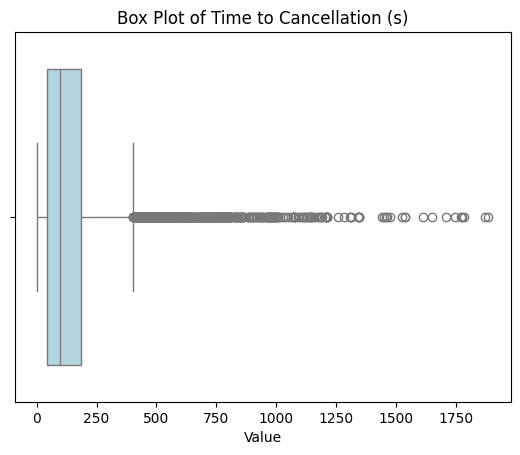

In [149]:
orders_df_no_outliers = orders_df[orders_df['cancellations_time_in_seconds']<=2000]

sns.boxplot(data=orders_df_no_outliers, x="cancellations_time_in_seconds", color="lightblue")
plt.title("Box Plot of Time to Cancellation (s)")
plt.xlabel("Value")
plt.show()

Note that cancellations_time_in_seconds only records non-null cancellation times for orders cancelled by client. All orders cancelled by the system have no cancellation time recorded. 

Based on this fact, it may be safe to assume that orders cancelled by the system are cancelled instantly. This seems like a reasonable assumption, as the system may cancel an order instantly due to lack of immediate availability. However, clients may cancel orders hours after initially placing it for various reasons.

In [150]:
# cancellation time null count grouped by order status
grouped_cancellation_times = orders_df.groupby('order_status')['cancellations_time_in_seconds'].apply(lambda x: x.isnull().sum()).reset_index()
pd.DataFrame(data=grouped_cancellation_times, index=grouped_cancellation_times.index).rename(columns={'cancellations_time_in_seconds': 'Null Count: Cancellation Time', 'order_status': 'Order Status'})

,Order Status,Null Count: Cancellation Time
0,Client Cancelled,0
1,System Cancelled,3409


Let's examine average time to cancellation stratified by hour of day and driver assignment status. 

In [151]:
avg_to_cancellation = orders_df_no_outliers.groupby(by=['hr', 'is_driver_assigned'])['cancellations_time_in_seconds'].mean().reset_index()

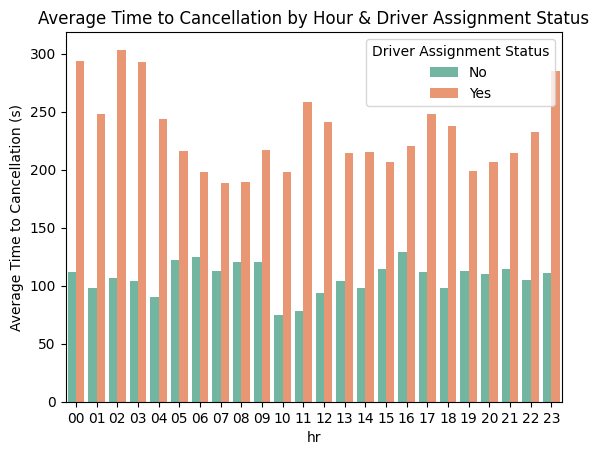

In [152]:
ax = sns.barplot(data=avg_to_cancellation, x="hr", y="cancellations_time_in_seconds", hue="is_driver_assigned", palette="Set2")
plt.title("Average Time to Cancellation by Hour & Driver Assignment Status")
plt.ylabel("Average Time to Cancellation (s)")

# # Annotate legend labels
# handles, labels = ax.get_legend_handles_labels()
# custom_labels = [
#     "0 (no driver assigned)",
#     "1 (driver assigned)",
# ]
ax.legend(title="Driver Assignment Status")

plt.show()

Across all hours, the average time to cancellation is longer for orders where a driver was assigned compared to orders with no driver assigned. For a given hour, the difference in average cancellation time between driver assignment ranges from 150 seconds on the larger end (2 am) to < 50 seconds on the lower end (5 am). 

This trend in longer average cancellation times for rides with driver assignment aligns with our findings above: 
- Recall the following: 
    - Nearly all orders cancelled after driver assignment were cancelled by the client, whereas order cancelled prior to driver assignment were more likely to be cancelled by the system (57% system, 43% client). 
    - We may assume that orders cancelled by the system are rejected instantly. 
- Therefore, since nearly all orders cancelled after driver assignment were cancelled by clients, and clients typically take longer to cancel orders then the system, it should be expected that average time to cancellation is much higher for orders with driver assigned vs. without driver assignment, across all hours of the day.

**Question 4**

Plot the distribution of average ETA by hours. How can this plot be explained?

In [153]:
avg_eta_by_hr = orders_df.groupby(['hr'])['m_order_eta'].agg('mean').reset_index()

avg_eta_by_hr.sort_values(by='m_order_eta', ascending=False)

,hr,m_order_eta
8,08,636.910828
7,07,583.358974
17,17,519.742515
9,09,504.891026
15,15,454.790210
12,12,440.787879
16,16,440.568182
13,13,428.025000
6,06,427.148936
18,18,419.186567


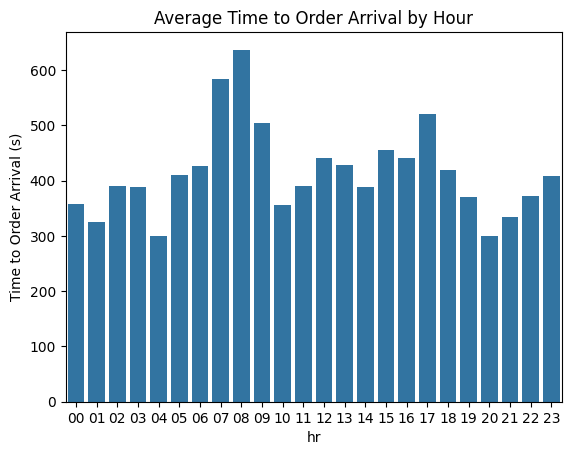

In [154]:
sns.barplot(data=avg_eta_by_hr, x="hr", y="m_order_eta")
plt.title("Average Time to Order Arrival by Hour")
plt.ylabel("Time to Order Arrival (s)")
plt.show()

In general, we see the following trends in order ETA:
- Average ETA is longest around 7-8 am (~600 seconds/10 minutes) and 5 pm (~550 seconds/9 minutes)
- Average ETA is shortest around 4 am and 8 pm (~300 seconds/5 minutes). After each of those times, average ETA increases steadily.

Most people travel to work around 7-8 am and leave around 5 pm, so rides are likely in high demand during these hours. Since drivers are likely busiest during these hours, the time to order arrival is likely to be longer as well. This trend is similar to that of which we saw with the number of cancelled orders by hour, which also peaked around 8 am.

**Question 5**

Using the h3 and folium packages, calculate how many sizes 8 hexes contain 80% of all orders from the original data sets and visualise the hexes, colouring them by the number of fails on the map.

In [155]:
import h3
import folium 

print(h3.__version__)
print(folium.__version__)

4.1.2
0.19.2


In [156]:
orders_df.head()

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds,order_status,is_driver_assigned,hr,min,sec
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0,Client Cancelled,Yes,18,08,07
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0,Client Cancelled,No,20,57,32
2,12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0,Client Cancelled,Yes,12,07,50
3,13:50:20,-1.054671,51.460544,658.0,3000582941169,4,1,62.0,Client Cancelled,Yes,13,50,20
4,21:24:45,-0.967605,51.458236,NaN,3000583140877,9,0,NaN,System Cancelled,No,21,24,45


In [157]:
def visualize_hexagons(hexagons, color="red", folium_map=None):
    """
    hexagons is a list of hexcluster. Each hexcluster is a list of hexagons. 
    eg. [[hex1, hex2], [hex3, hex4]]
    """
    polylines = []
    lat = []
    lng = []
    for hex in hexagons:
        polygons = h3.h3SetToMultiPolygon([hex], geo_json=False)
        # flatten polygons into loops.
        outlines = [loop for polygon in polygons for loop in polygon]
        polyline = [outline + [outline[0]] for outline in outlines][0]
        lat.extend(map(lambda v:v[0],polyline))
        lng.extend(map(lambda v:v[1],polyline))
        polylines.append(polyline)
    
    if folium_map is None:
        m = folium.Map(location=[sum(lat)/len(lat), sum(lng)/len(lng)], zoom_start=13, tiles='cartodbpositron')
    else:
        m = folium_map
    for polyline in polylines:
        my_PolyLine=folium.PolyLine(locations=polyline,weight=8,color=color)
        m.add_child(my_PolyLine)
    return m
    

def visualize_polygon(polyline, color):
    polyline.append(polyline[0])
    lat = [p[0] for p in polyline]
    lng = [p[1] for p in polyline]
    m = folium.Map(location=[sum(lat)/len(lat), sum(lng)/len(lng)], zoom_start=13, tiles='cartodbpositron')
    my_PolyLine=folium.PolyLine(locations=polyline,weight=8,color=color)
    m.add_child(my_PolyLine)
    return m

In [158]:
outer = [
    (37.804, -122.412),
    (37.778, -122.507),
    (37.733, -122.501)
]

poly = h3.LatLngPoly(outer)
print(poly)

<LatLngPoly: [3]>


In [159]:
d = poly.__geo_interface__
d

{'type': 'Polygon',
 'coordinates': (((-122.412, 37.804),
   (-122.507, 37.778),
   (-122.501, 37.733),
   (-122.412, 37.804)),)}

In [160]:
h3_address = h3.geo_to_h3shape(d) # lat, lng, hex resolution - {'type': 'Point', 'coordinates': (37.3615593, -122.0553238, 9)}
m = visualize_hexagons([h3_address])
display(m)

AttributeError: module 'h3' has no attribute 'h3SetToMultiPolygon'